In [1]:
import os
import tensorflow as tf

BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (299, 299)
SEED = 42

def extract_family_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[
        -2
    ]  # Assumes the structure '/.../family_genus_species/image.jpg'

    # Split the folder name assuming the format "family_genus_species"
    family_genus_species = tf.strings.split(folder_name, "_")
    family = family_genus_species[-3]
    genus = family_genus_species[-2]
    species = family_genus_species[-2] + " " + family_genus_species[-1]

    return family, genus, species

def process_path(path, family_labels, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [299, 299])

    # Get the family, genus, and species labels
    family, genus, species = extract_family_genus_and_species_from_path(path)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    family_labels = set()
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

                # Extract family, genus, and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                family, genus, species = folder_name.split("_")

                species = genus + " " + species

                # Collect unique family, genus, and species names
                family_labels.add(family)
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda x: process_path(x, family_labels, genus_labels, species_labels),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

# Usage
train_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
)
val_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
)
test_ds, family_labels, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
)

2024-10-23 10:06:21.846601: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-23 10:06:21.846625: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-23 10:06:21.846630: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-23 10:06:21.846641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-23 10:06:21.846649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [3]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

In [4]:
import matplotlib.pyplot as plt

#for image, _ in train_ds.take(1):
#  plt.figure(figsize=(10, 10))
#  first_image = image[0]
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#    plt.imshow(augmented_image[0] / 255)
#    plt.axis('off')

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_hierarchical_classifier(
    IMG_SIZE,
    family_labels,
    genus_labels,
    species_labels,
    data_augmentation
):
    # Image Preprocessing
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
    base_model = tf.keras.applications.ResNet50V2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Define the inputs and apply augmentation
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Enhanced shared dense layer with batch normalization
    shared_dense = tf.keras.layers.Dense(512, activation=None)(x)
    shared_dense = tf.keras.layers.BatchNormalization()(shared_dense)
    shared_dense = tf.keras.layers.Activation('relu')(shared_dense)
    shared_dense = tf.keras.layers.Dropout(0.3)(shared_dense)

    # Family transformation and output
    family_transform = tf.keras.layers.Dense(384, activation=None, name='family_transform')(shared_dense)
    family_transform = tf.keras.layers.BatchNormalization()(family_transform)
    family_transform = tf.keras.layers.Activation('relu')(family_transform)
    family_transform = tf.keras.layers.Dropout(0.2)(family_transform)
    family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(family_transform)

    # Enhanced family features with attention mechanism
    family_attention = tf.keras.layers.Dense(512, activation='sigmoid')(family_transform)
    family_features = tf.keras.layers.Multiply()([shared_dense, family_attention])
    family_features = tf.keras.layers.Concatenate()([family_features, family_output])

    # Genus transformation and output with hierarchical attention
    genus_transform = tf.keras.layers.Dense(256, activation=None)(family_features)
    genus_transform = tf.keras.layers.BatchNormalization()(genus_transform)
    genus_transform = tf.keras.layers.Activation('relu')(genus_transform)
    genus_transform = tf.keras.layers.Dropout(0.2)(genus_transform)
    
    # Residual connection for genus
    genus_residual = tf.keras.layers.Dense(256, activation='relu')(family_output)
    genus_hidden = tf.keras.layers.Add()([genus_transform, genus_residual])
    genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

    # Enhanced genus features with attention
    genus_attention = tf.keras.layers.Dense(512, activation='sigmoid')(genus_hidden)
    genus_features = tf.keras.layers.Multiply()([shared_dense, genus_attention])
    genus_features = tf.keras.layers.Concatenate()([genus_features, family_output, genus_output])

    # Species transformation and output with hierarchical attention
    species_transform = tf.keras.layers.Dense(256, activation=None)(genus_features)
    species_transform = tf.keras.layers.BatchNormalization()(species_transform)
    species_transform = tf.keras.layers.Activation('relu')(species_transform)
    species_transform = tf.keras.layers.Dropout(0.2)(species_transform)
    
    # Residual connection for species
    species_residual = tf.keras.layers.Dense(256, activation='relu')(tf.keras.layers.Concatenate()([family_output, genus_output]))
    species_hidden = tf.keras.layers.Add()([species_transform, species_residual])
    species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

    # Create the hierarchical model
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output])
    
    return model

# Simpler consistency terms with element-wise comparison
def hierarchical_loss():
    def loss_function(y_true, y_pred):
        # Standard categorical crossentropy for each level
        family_loss = tf.keras.losses.categorical_crossentropy(y_true[0], y_pred[0])
        genus_loss = tf.keras.losses.categorical_crossentropy(y_true[1], y_pred[1])
        species_loss = tf.keras.losses.categorical_crossentropy(y_true[2], y_pred[2])

        # Consistency terms as element-wise absolute differences
        family_genus_consistency = tf.reduce_mean(
            tf.abs(y_pred[1] - tf.matmul(y_pred[0], tf.transpose(y_true[0])))
        )
        
        genus_species_consistency = tf.reduce_mean(
            tf.abs(y_pred[2] - tf.matmul(y_pred[1], tf.transpose(y_true[1])))
        )
        
        # Weighted sum of losses
        total_loss = (
            1.0 * family_loss +
            1.2 * genus_loss +
            1.5 * species_loss +
            0.3 * family_genus_consistency +
            0.3 * genus_species_consistency
        )
        
        return total_loss
    
    return loss_function

# Example usage
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        loss_weights={
            'family': 1.0,
            'genus': 1.2,
            'species': 1.5
        },
        metrics={
            'family': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')],
            'genus': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')],
            'species': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
        }
    )
    return model


model = create_hierarchical_classifier(
    IMG_SIZE=IMG_SIZE,
    family_labels=family_labels,  # Your existing label lists
    genus_labels=genus_labels,
    species_labels=species_labels,
    data_augmentation=data_augmentation
)

# Compile the model
model = compile_model(model)

# Create learning rate scheduler for better training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Create model checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'RES50V2_299_ANTROP_MO_HACPL.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Training the model
history = model.fit(
    train_ds,  # Your training dataset
    validation_data=val_ds,  # Your validation dataset
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping,],
    verbose=1
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 452ms/step - family_accuracy: 0.4888 - family_loss: 1.7035 - family_top3_accuracy: 0.7184 - genus_accuracy: 0.3376 - genus_loss: 3.2269 - genus_top3_accuracy: 0.4948 - loss: 9.1755 - species_accuracy: 0.3398 - species_loss: 4.2432 - species_top3_accuracy: 0.4822 - val_family_accuracy: 0.8191 - val_family_loss: 0.5495 - val_family_top3_accuracy: 0.9537 - val_genus_accuracy: 0.7541 - val_genus_loss: 1.0981 - val_genus_top3_accuracy: 0.9054 - val_loss: 3.1700 - val_species_accuracy: 0.7493 - val_species_loss: 1.5115 - val_species_top3_accuracy: 0.9075 - learning_rate: 0.0010
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 80s 442ms/step - family_accuracy: 0.7673 - family_loss: 0.7183 - family_top3_accuracy: 0.9399 - genus_accuracy: 0.7036 - genus_loss: 1.2763 - genus_top3_accuracy: 0.8815 - loss: 3.7075 - species_accuracy: 0.6963 - species_loss: 1.7122 - species_top3_accuracy: 0.8612 - val_family_accuracy: 0.8681 - val_family_loss: 0.4029 - val_family_t

In [11]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - family_accuracy: 0.8937 - family_loss: 0.2992 - family_top3_accuracy: 0.9779 - genus_accuracy: 0.8812 - genus_loss: 0.4385 - genus_top3_accuracy: 0.9629 - loss: 1.3493 - species_accuracy: 0.8789 - species_loss: 0.6115 - species_top3_accuracy: 0.9619
Family Acc: 0.902
Genus Acc: 0.980
Species Acc: 0.893


In [19]:
base_model = model.layers[2]

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [20]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001/10),
  loss='categorical_crossentropy',
        loss_weights={
            'family': 1.0,
            'genus': 1.2,
            'species': 1.5
        },
        metrics={
            'family': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')],
            'genus': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')],
            'species': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
        }
)

In [21]:
fine_tune_epochs = 5
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
)

Epoch 11/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 112s 564ms/step - family_accuracy: 0.8590 - family_loss: 0.4343 - family_top3_accuracy: 0.9698 - genus_accuracy: 0.8379 - genus_loss: 0.6427 - genus_top3_accuracy: 0.9507 - loss: 1.9177 - species_accuracy: 0.8390 - species_loss: 0.8403 - species_top3_accuracy: 0.9481 - val_family_accuracy: 0.9233 - val_family_loss: 0.2335 - val_family_top3_accuracy: 0.9848 - val_genus_accuracy: 0.8992 - val_genus_loss: 0.4015 - val_genus_top3_accuracy: 0.9606 - val_loss: 1.2074 - val_species_accuracy: 0.8971 - val_species_loss: 0.5604 - val_species_top3_accuracy: 0.9620
Epoch 12/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 545ms/step - family_accuracy: 0.8999 - family_loss: 0.3044 - family_top3_accuracy: 0.9832 - genus_accuracy: 0.8832 - genus_loss: 0.4595 - genus_top3_accuracy: 0.9686 - loss: 1.3700 - species_accuracy: 0.8779 - species_loss: 0.6061 - species_top3_accuracy: 0.9678 - val_family_accuracy: 0.9330 - val_family_loss: 0.2113 - val_family_top3_accuracy: 0.9869 

In [22]:
results = model.evaluate(test_ds)

print(f"Family Acc: {results[4]:.3f}")
print(f"Genus Acc: {results[5]:.3f}")
print(f"Species Acc: {results[6]:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - family_accuracy: 0.9432 - family_loss: 0.1846 - family_top3_accuracy: 0.9859 - genus_accuracy: 0.9289 - genus_loss: 0.2943 - genus_top3_accuracy: 0.9799 - loss: 0.8983 - species_accuracy: 0.9247 - species_loss: 0.4193 - species_top3_accuracy: 0.9767
Family Acc: 0.936
Genus Acc: 0.987
Species Acc: 0.922


In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224),top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


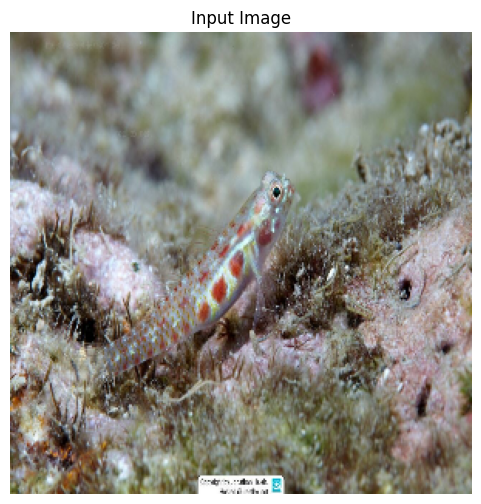

Top 3 Family Predictions:
b'Gobiidae': 0.8884
b'Tripterygiidae': 0.0873
b'Syngnathidae': 0.0234

Top 3 Genus Predictions:
b'Eviota': 0.7626
b'Pleurosicya': 0.1314
b'Corythoichthys': 0.0446

Top 3 Species Predictions:
b'Eviota melasma': 0.3464
b'Eviota albolineata': 0.2122
b'Ucla xenogrammus': 0.1282


In [24]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/66367_web_Eviota_melasma_6.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Trimma_macrophthalmus/21775_web_Trimma_macrophthalmus_32.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Istigobius_decoratus/21689_web_Istigobius_decoratus_441.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Istigobius_decoratus/86970_web_Istigobius_decoratus_496.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Trimma_macrophthalmus/65426378_fish_photo_10654.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/96590_web_Eviota_melasma_60.jpeg'


top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━

2024-10-23 10:44:30.862554: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


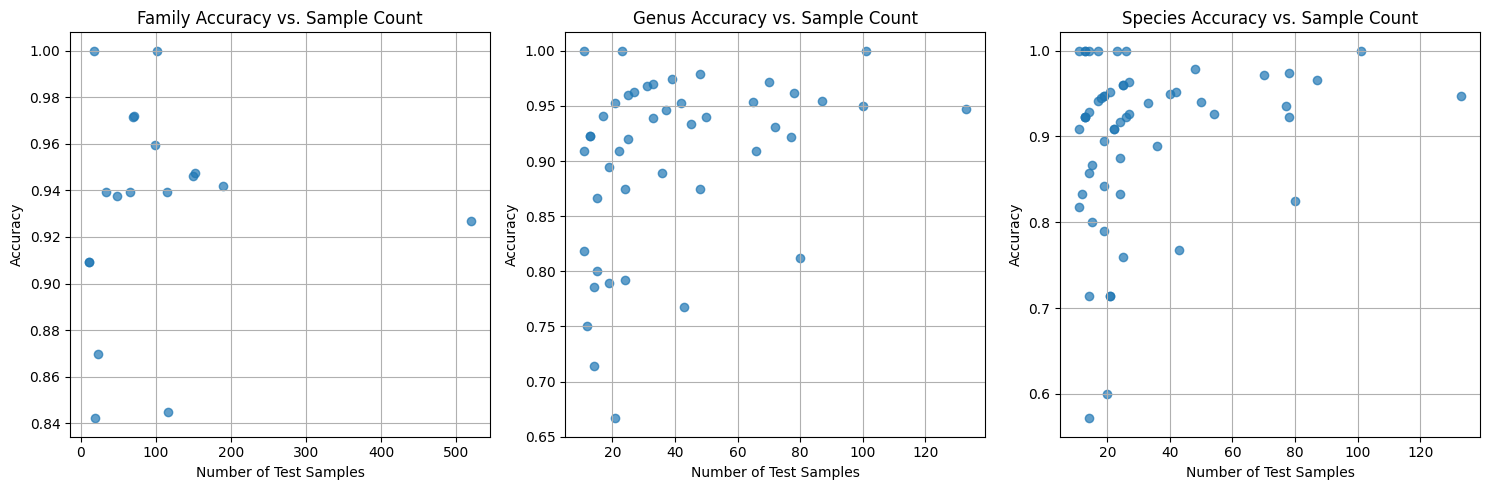

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def evaluate_accuracy_per_label(test_ds, model, family_labels, genus_labels, species_labels):
    # Initialize dictionaries to store correct predictions and counts for each label
    family_correct = defaultdict(int)
    genus_correct = defaultdict(int)
    species_correct = defaultdict(int)
    
    family_total = defaultdict(int)
    genus_total = defaultdict(int)
    species_total = defaultdict(int)

    # Iterate over the test dataset
    for images, labels in test_ds:
        # Get true labels
        true_family = tf.argmax(labels["family"], axis=1).numpy()
        true_genus = tf.argmax(labels["genus"], axis=1).numpy()
        true_species = tf.argmax(labels["species"], axis=1).numpy()

        # Get model predictions
        family_preds, genus_preds, species_preds = model.predict(images)
        pred_family = np.argmax(family_preds, axis=1)
        pred_genus = np.argmax(genus_preds, axis=1)
        pred_species = np.argmax(species_preds, axis=1)

        # Update counts for each label
        for true_fam, pred_fam, true_gen, pred_gen, true_spe, pred_spe in zip(
            true_family, pred_family, true_genus, pred_genus, true_species, pred_species
        ):
            # Update family counts
            family_total[true_fam] += 1
            if true_fam == pred_fam:
                family_correct[true_fam] += 1

            # Update genus counts
            genus_total[true_gen] += 1
            if true_gen == pred_gen:
                genus_correct[true_gen] += 1

            # Update species counts
            species_total[true_spe] += 1
            if true_spe == pred_spe:
                species_correct[true_spe] += 1

    # Calculate accuracy for each label
    family_accuracy = {family_labels[k]: family_correct[k] / family_total[k] for k in family_total if family_total[k] > 0}
    genus_accuracy = {genus_labels[k]: genus_correct[k] / genus_total[k] for k in genus_total if genus_total[k] > 0}
    species_accuracy = {species_labels[k]: species_correct[k] / species_total[k] for k in species_total if species_total[k] > 0}
    
    # Create dataframes for plotting
    family_df = pd.DataFrame({
        'Label': list(family_accuracy.keys()),
        'Accuracy': list(family_accuracy.values()),
        'Count': [family_total[family_labels.index(label)] for label in family_accuracy.keys()]
    })
    
    genus_df = pd.DataFrame({
        'Label': list(genus_accuracy.keys()),
        'Accuracy': list(genus_accuracy.values()),
        'Count': [genus_total[genus_labels.index(label)] for label in genus_accuracy.keys()]
    })
    
    species_df = pd.DataFrame({
        'Label': list(species_accuracy.keys()),
        'Accuracy': list(species_accuracy.values()),
        'Count': [species_total[species_labels.index(label)] for label in species_accuracy.keys()]
    })

    # Plot the correlations
    plt.figure(figsize=(15, 5))

    # Family plot
    plt.subplot(1, 3, 1)
    plt.scatter(family_df['Count'], family_df['Accuracy'], alpha=0.7)
    plt.title('Family Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Genus plot
    plt.subplot(1, 3, 2)
    plt.scatter(genus_df['Count'], genus_df['Accuracy'], alpha=0.7)
    plt.title('Genus Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Species plot
    plt.subplot(1, 3, 3)
    plt.scatter(species_df['Count'], species_df['Accuracy'], alpha=0.7)
    plt.title('Species Accuracy vs. Sample Count')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return family_df, genus_df, species_df

# Usage
family_df, genus_df, species_df = evaluate_accuracy_per_label(
    test_ds, model, family_labels, genus_labels, species_labels
)

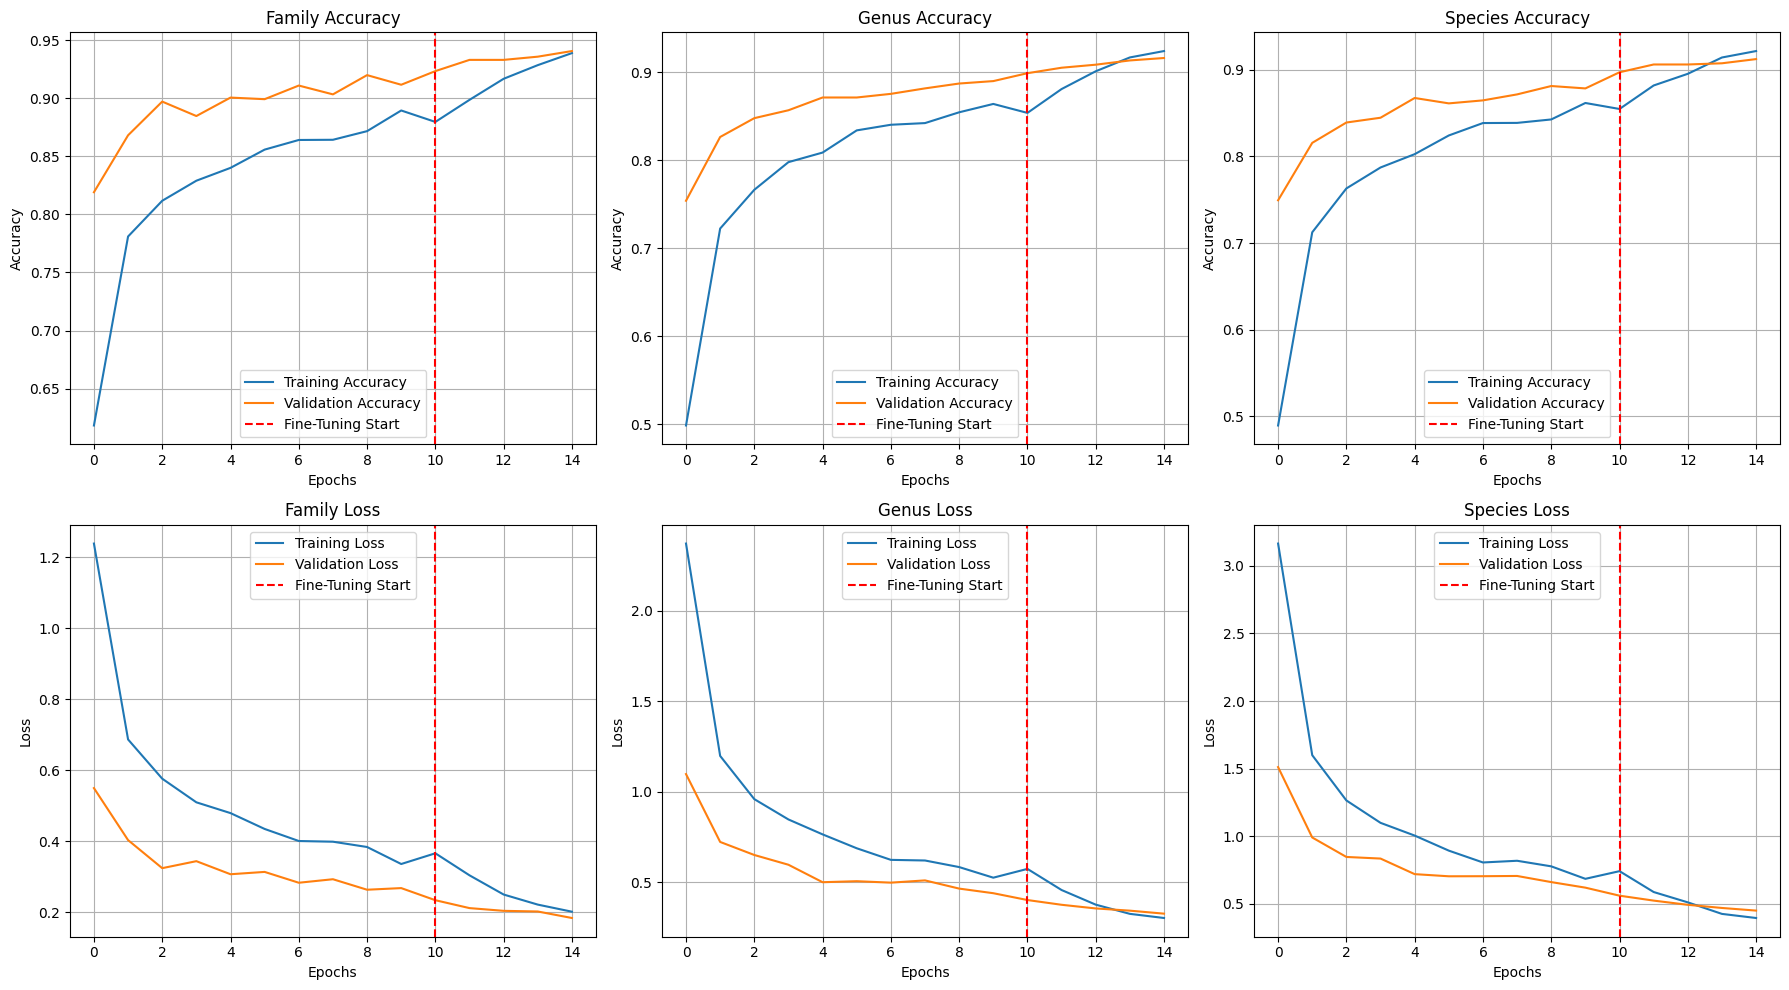

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# fine_tune_at = len(history.epoch)  # Get the epoch where fine-tuning started
plot_training_history(history, history_fine, fine_tune_at=10)

In [28]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
train_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

Genus Misclassifications: 141
Genus Misclassifications Respecting Family: 49 (34.75%)

Top Genus Misclassifications:
        True Genus Predicted Genus  Count
32      Fusigobius      Istigobius      8
4   Enneapterygius            Ucla      5
28  Corythoichthys      Istigobius      4
63     Enneanectes     Helcogramma      3
37   Sebastapistes    Scorpaenodes      3
6      Cirripectes        Ecsenius      3
57      Istigobius      Fusigobius      3
23  Corythoichthys      Fusigobius      3
46     Pomacanthus     Pomacentrus      3
30    Doryrhamphus  Corythoichthys      2

Species Misclassifications: 153
Species Misclassifications Respecting Genus: 20 (13.07%)
Species Misclassifications Respecting Family: 65 (42.48%)

Top Species Misclassifications:
                     True Species      Predicted Species  Count
46           Fusigobius_neophytus   Istigobius_decoratus      8
44       Paragobiodon_lacunicolus  Paragobiodon_modestus      5
10                 Eviota_melasma     Eviota_alb

2024-10-23 10:45:50.671398: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
